# Privacy - attack model - part1 : Wasserstein GAN

__Main goal__ : the main goal of this part is to use public data to build a generator able to produce the kind of output we want to reveal. Here we want to reveal images of hand written digits from 0 to 4. We use images of hand written digits from 5 to 9 to train the generator, so that the public and private dataset do not overlap.

__Reference for the WGAN__ : https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/

# Imports and Data

In [1]:
%load_ext autoreload
%autoreload 2

from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint

import tensorflow as tf

from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.constraints import Constraint

from matplotlib import pyplot
import numpy as np
import os

os.sys.path.append("./src")
from utils import plot_img
from utils import load_mnist_data

from models import wasserstein_loss
from models import define_critic
from models import define_generator
from models import generate_latent_points

# Import and settings

In [2]:
n_epochs = 30
latent_dim = 50

### Load image dataset and check if we have only images from 5 to 9

11493376/11490434 [==============================] - 1s 0us/step
train size : 29404
test size : 4861
total size : 34265


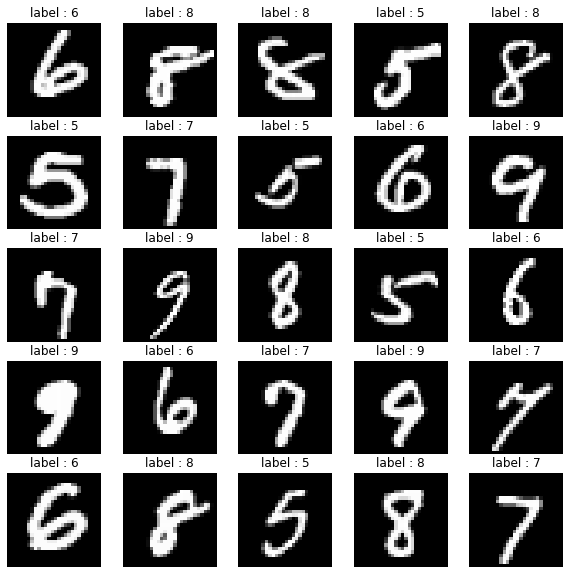

In [3]:
dataset, y_train, x_test, y_test = load_mnist_data("public")
plot_img(dataset, y_train)

### Select real samples

In [4]:
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels, -1 for 'real'
    y = -ones((n_samples, 1))
    return X, y

## Use the generator to generate n fake examples, with class labels

In [5]:
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels with 1.0 for 'fake'
    y = ones((n_samples, 1))
    return X, y

# Define the GAN

### Generate samples and save as a plot and save the model
The critic and standalone generator functions are defined in scr/models.py

In [6]:
def define_gan(generator, critic):
    # make weights in the critic not trainable
    critic.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the critic
    model.add(critic)
    # compile model
    opt = RMSprop(lr=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

Performances and models are saved regularly

In [7]:
def summarize_performance(step, g_model, c_model, latent_dim, n_samples=100):
    # prepare fake examples
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(10 * 10):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'attack_gan_plot_%04d.png' % (step+1)
    pyplot.savefig(os.path.join("model",filename1))
    pyplot.close()
    # save the generator model
    filename2 = os.path.join("model",'attack_gan_model_%04d.h5' % (step+1))
    g_model.save(filename2)
    # save the critic model
    filename3 = os.path.join("model",'attack_critic_model_weights_%04d.h5' % (step+1))
    c_model.save_weights(filename3)
    print('>Saved: %s and %s' % (filename1, filename2))

### Create a line plot of loss for the gan and save to file

In [8]:
def plot_history(d1_hist, d2_hist, g_hist):
    # plot history
    pyplot.plot(d1_hist, label='crit_real')
    pyplot.plot(d2_hist, label='crit_fake')
    pyplot.plot(g_hist, label='gen')
    pyplot.legend()
    pyplot.savefig(os.path.join("model",'attack_gan_loss.png'))
    pyplot.close()

# Training

### Train the generator and critic
The critic is trained x times more than the generator (here we choose x=5)

In [9]:
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs, n_batch=64, n_critic=5):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # lists for keeping track of loss
    c1_hist, c2_hist, g_hist = list(), list(), list()
    # manually enumerate epochs
    for i in range(n_steps):
        # update the critic more than the generator
        c1_tmp, c2_tmp = list(), list()
        for _ in range(n_critic):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update critic model weights
            c_loss1 = c_model.train_on_batch(X_real, y_real)
            c1_tmp.append(c_loss1)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update critic model weights
            c_loss2 = c_model.train_on_batch(X_fake, y_fake)
            c2_tmp.append(c_loss2)
        # store critic loss
        c1_hist.append(mean(c1_tmp))
        c2_hist.append(mean(c2_tmp))
        # prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = -ones((n_batch, 1))
        # update the generator via the critic's error
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        g_hist.append(g_loss)        
        # evaluate the model performance every 'epoch'
        if (i+1) % bat_per_epo == 0:
            print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
            summarize_performance(i, g_model, c_model, latent_dim)

    # line lots of loss
    plot_history(c1_hist, c2_hist, g_hist)

### Start the training

In [10]:
# size of the latent space
latent_dim = 50
# create the critic
critic = define_critic()
opt = RMSprop(lr=0.00005)
critic.compile(loss=wasserstein_loss, optimizer=opt)
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, critic)
print(dataset.shape)
# train model
train(generator, critic, gan_model, dataset, latent_dim, n_epochs=n_epochs)

(29404, 28, 28, 1)
>459, c1=-414.931, c2=-410.902 g=-16.252
>Saved: attack_gan_plot_0459.png and model/attack_gan_model_0459.h5
>918, c1=-1085.347, c2=-1039.647 g=101.680
>Saved: attack_gan_plot_0918.png and model/attack_gan_model_0918.h5
>1377, c1=-1991.493, c2=-1889.071 g=219.258
>Saved: attack_gan_plot_1377.png and model/attack_gan_model_1377.h5
>1836, c1=-3131.819, c2=-2950.479 g=-478.641
>Saved: attack_gan_plot_1836.png and model/attack_gan_model_1836.h5
>2295, c1=-4511.516, c2=-4237.254 g=-257.985
>Saved: attack_gan_plot_2295.png and model/attack_gan_model_2295.h5
>2754, c1=-6109.546, c2=-5680.826 g=-1520.389
>Saved: attack_gan_plot_2754.png and model/attack_gan_model_2754.h5
>3213, c1=-7949.758, c2=-7420.423 g=-2304.622
>Saved: attack_gan_plot_3213.png and model/attack_gan_model_3213.h5
>3672, c1=-10025.485, c2=-9364.533 g=-2749.031
>Saved: attack_gan_plot_3672.png and model/attack_gan_model_3672.h5
>4131, c1=-12321.439, c2=-11447.630 g=-3233.463
>Saved: attack_gan_plot_4131.png